# Тематическая классификация длинных текстов

In [0]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt

In [0]:
import sys; 
sys.path.append('./stepik-dl-nlp')

In [0]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import scipy

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

from tqdm import tqdm

import re

import nltk
from nltk.corpus import wordnet

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

import sklearn

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
init_random_seed()

## Предобработка текстов и подготовка признаков

In [4]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

In [5]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [6]:
MAX_DF = 0.8
MIN_COUNT = 5 
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


### Распределение классов

In [7]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


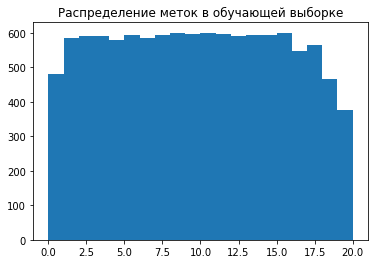

In [8]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

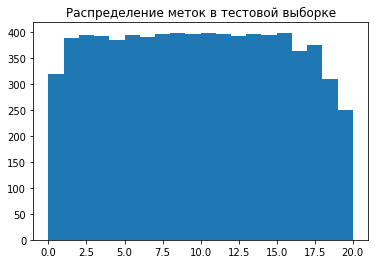

In [9]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

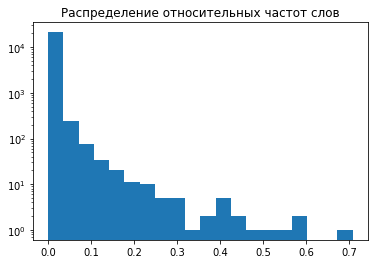

In [10]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

### Функция проверки результата через обучение LogReg

In [0]:
def test_on_model(train_data, train_target, test_data, test_target, input_size=UNIQUE_WORDS_N, output_size=UNIQUE_LABELS_N):
    train_dataset = SparseFeaturesDataset(train_data, train_target)
    test_dataset = SparseFeaturesDataset(test_data, test_target)

    model = nn.Linear(input_size, output_size)

    scheduler = lambda optim: \
        torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

    best_val_loss, best_model = train_eval_loop(model=model,
                                                train_dataset=train_dataset,
                                                val_dataset=test_dataset,
                                                criterion=F.cross_entropy,
                                                lr=1e-1,
                                                epoch_n=200,
                                                batch_size=32,
                                                l2_reg_alpha=0,
                                                lr_scheduler_ctor=scheduler)

    test_pred = predict_with_model(best_model, test_dataset)

    test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                                torch.from_numpy(test_source['target']).long())

    loss = float(test_loss)
    print('Среднее значение функции потерь на валидации', loss)
    accuracy = accuracy_score(test_source['target'], test_pred.argmax(-1))
    print('Доля верных ответов', accuracy)
    return loss, accuracy

### Взвешивание призначов через TFIDF

In [12]:
def do_tfidf(train_tokenized, test_tokenized, vocabulary, word_doc_freq):
    VECTORIZATION_MODE = 'tfidf'
    train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
    test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
    return train_vectors, test_vectors

train_vectors, test_vectors = do_tfidf(train_tokenized, test_tokenized, vocabulary, word_doc_freq)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в обучающей выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в обучающей выборке 721529
Процент заполненности матрицы признаков 0.44%


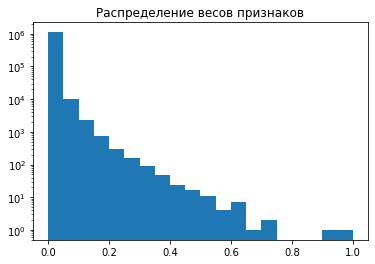

In [13]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

In [0]:
tfidf_loss, tfidf_accuracy = test_on_model(train_vectors, train_source['target'], test_vectors, test_source['target'])

### TF взвешивание

In [15]:
def do_tf(train_tokenized, test_tokenized, vocabulary, word_doc_freq):
    VECTORIZATION_MODE = 'tf'
    train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
    test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
    return train_vectors, test_vectors

train_vectors, test_vectors = do_tf(train_tokenized, test_tokenized, vocabulary, word_doc_freq)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)


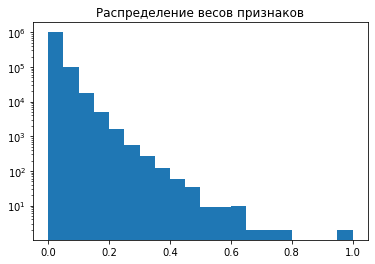

In [16]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

In [0]:
tf_loss, tf_accuracy = test_on_model(train_vectors, train_source['target'], test_vectors, test_source['target'])

### IDF взвешивание

In [18]:
def do_idf(train_tokenized, test_tokenized, vocabulary, word_doc_freq):
    VECTORIZATION_MODE = 'idf'
    train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
    test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
    return train_vectors, test_vectors


train_vectors, test_vectors = do_idf(train_tokenized, test_tokenized, vocabulary, word_doc_freq)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)


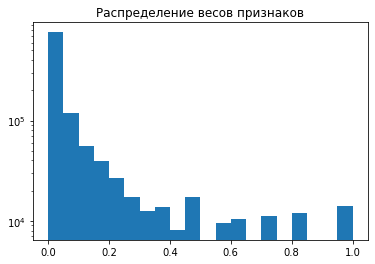

In [19]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

In [0]:
idf_loss, idf_accuracy = test_on_model(train_vectors, train_source['target'], test_vectors, test_source['target'])

###  Бинарное взвешивание признаков

In [21]:
def do_bin(train_tokenized, test_tokenized, vocabulary, word_doc_freq):
    VECTORIZATION_MODE = 'bin'
    train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
    test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
    return train_vectors, test_vectors


train_vectors, test_vectors = do_bin(train_tokenized, test_tokenized, vocabulary, word_doc_freq)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)


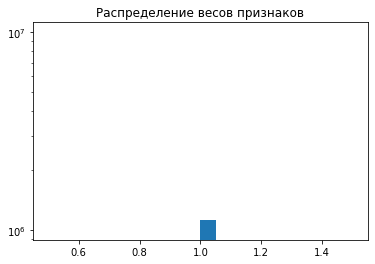

In [22]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

In [0]:
bin_loss, bin_accuracy = test_on_model(train_vectors, train_source['target'], test_vectors, test_source['target'])

### Метод PMI

In [0]:
def pmi_vectorize_texts(tokenized_texts, text_classes, vocabulary, scale=True):
    # считаем количество употреблений каждого слова в каждом классе
    unique_num_classes = len(set(text_classes))
    classes_var = np.zeros(unique_num_classes) # Считаем частоту употребления классов


    words_by_classes_matrix = scipy.sparse.dok_matrix((unique_num_classes, len(vocabulary)), dtype='float32')
    words_count_matrix = scipy.sparse.dok_matrix((len(tokenized_texts), len(vocabulary)), dtype='float32')
    for text_index, text in enumerate(tokenized_texts):
        text_class = text_classes[text_index]
        for word in text:
            if word in vocabulary:
                word_index = vocabulary[word] 
                words_by_classes_matrix[text_class, word_index] += 1
                words_count_matrix[text_index, word_index] += 1
                classes_var[text_class - 1 ] += 1 # text_index - 1 т.к. индексы массиве с 0

    classes_var /= len(text_classes)

    for text_index, text in enumerate(tokenized_texts):
        text_class = text_classes[text_index]
        p_class = classes_var[text_class - 1]
        for word in text:
          if word in vocabulary:
            word_index = vocabulary[word]
            # pmi - вероятность встретить слово в классе / (вероятность встретить слово * вероятность класса)
            words_count_matrix[text_index, word_index] = words_by_classes_matrix[text_class, word_index] / (words_count_matrix[text_index, word_index] * p_class)
    
    if scale:
      words_count_matrix = words_count_matrix.tocsc()
      words_count_matrix -= words_count_matrix.min()
      words_count_matrix /= (words_count_matrix.max() + 1e-6)

    return words_count_matrix.tocsr()

def do_pmi(train_tokenized, test_tokenized, train_source, test_source, voc):
    train_vectors = pmi_vectorize_texts(train_tokenized, text_classes=train_source['target'], vocabulary=voc)
    test_vectors = pmi_vectorize_texts(test_tokenized, text_classes=test_source['target'], vocabulary=voc)
    return train_vectors, test_vectors

#train_vectors, test_vectors = do_pmi(train_tokenized, test_tokenized, train_source, test_source, vocabulary)
#print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
#print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)

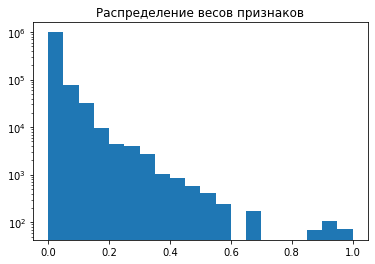

In [25]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

In [0]:
pmi_loss, pmi_accuracy = test_on_model(train_vectors, train_source['target'], test_vectors, test_source['target'])

### LSA

In [27]:
def lsa_vectorize_texts(svd_model, tokenized_texts, vocabulary):
    # считаем количество употреблений каждого слова в каждом классе
    words_count_matrix = scipy.sparse.dok_matrix((len(tokenized_texts), len(vocabulary)), dtype='float32')
    for text_index, text in enumerate(tokenized_texts):
        for word in text:
            if word in vocabulary:
                words_count_matrix[text_index, vocabulary[word]] += 1

    result = svd_model.fit_transform(words_count_matrix)
    result = scipy.sparse.dok_matrix(result)
    return result.tocsr()

def do_lsa(train_tokenized, test_tokenized, vocabulary, n_components):
    svd_model = sklearn.decomposition.TruncatedSVD(n_components=n_components, algorithm='randomized', n_iter=100)
    train_vectors = lsa_vectorize_texts(svd_model, train_tokenized, vocabulary=vocabulary)
    test_vectors = lsa_vectorize_texts(svd_model, test_tokenized, vocabulary=vocabulary)
    return train_vectors, test_vectors

N_COMPONENS = UNIQUE_LABELS_N
train_vectors, test_vectors = do_lsa(train_tokenized, test_tokenized, vocabulary, N_COMPONENS)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)

Размерность матрицы признаков обучающей выборки (11314, 20)
Размерность матрицы признаков тестовой выборки (7532, 20)


In [0]:
lsa_loss, lsa_accuracy = test_on_model(train_vectors, train_source['target'], test_vectors, test_source['target'], input_size=N_COMPONENS)

### Выводы по взвешиванию признаков:


In [0]:
def print_score(results):
    sorted_methods_results = sorted(results, key=lambda x: results[x][1])

    print('Методы по возрастанию скора:')
    for method_name in sorted_methods_results:
        loss, accuracy = results[method_name]
        print(f'Метод {method_name}: loss {loss}, accuracy {accuracy}')

In [31]:
methods_results = {
    'TFIDF': (tfidf_loss, tfidf_accuracy),
    'TF': (tf_loss, tf_accuracy),
    'IDF': (idf_loss, idf_accuracy),
    'Binary Vectorization': (bin_loss, bin_accuracy),
    'PMI': (pmi_loss, pmi_accuracy),
    'LSA': (lsa_loss, lsa_accuracy)
}

print_score(methods_results)

Методы по возрастанию скора:
Метод LSA: loss 10.68907356262207, accuracy 0.058417419012214554
Метод Binary Vectorization: loss 3.9019036293029785, accuracy 0.7093733404142326
Метод IDF: loss 0.9739583134651184, accuracy 0.7590281465746149
Метод TFIDF: loss 0.9288857579231262, accuracy 0.7712426978226234
Метод TF: loss 0.6550551652908325, accuracy 0.814922995220393
Метод PMI: loss 0.4661864936351776, accuracy 0.8570100902814658


### Добавим лемматизацию и переобучим три лучших модели

In [0]:
def get_wordnet_pos(word):
    # Определим части речи
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def do_lemmatize(text_corpus):
    result = list()
    lemma = nltk.wordnet.WordNetLemmatizer()
    for text in text_corpus:
        result.append([lemma.lemmatize(word, get_wordnet_pos(word)) for word in text])
    return result

train_lemmatize = do_lemmatize(train_tokenized)
test_lemmatize = do_lemmatize(test_tokenized)

In [0]:
train_lemmatized_vectors, test_lemmatized_vectors = do_pmi(train_lemmatize, test_lemmatize, train_source, test_source, vocabulary)
pmi_lemmatized_loss, pmi_lemmatized_accuracy = test_on_model(train_lemmatized_vectors, train_source['target'], test_lemmatized_vectors, test_source['target'])

In [0]:
train_lemmatized_vectors, test_lemmatized_vectors = do_tf(train_lemmatize, test_lemmatize, vocabulary, word_doc_freq)
tf_lemmatized_loss, tf_lemmatized_accuracy = test_on_model(train_lemmatized_vectors, train_source['target'], test_lemmatized_vectors, test_source['target'])

In [0]:
train_lemmatized_vectors, test_lemmatized_vectors = do_tfidf(train_lemmatize, test_lemmatize, vocabulary, word_doc_freq)
tfidf_lemmatized_loss, tfidf_lemmatized_accuracy = test_on_model(train_lemmatized_vectors, train_source['target'], test_lemmatized_vectors, test_source['target'])

In [36]:
lemmatize_score_models = {
    'TFIDF': (tfidf_lemmatized_loss, tfidf_lemmatized_accuracy),
    'TF': (tf_lemmatized_loss, tf_lemmatized_accuracy),
    'PMI': (pmi_lemmatized_loss, pmi_lemmatized_accuracy),
}

print_score(lemmatize_score_models)

Методы по возрастанию скора:
Метод TFIDF: loss 0.9130680561065674, accuracy 0.7691184280403611
Метод TF: loss 0.6494341492652893, accuracy 0.8153212958045671
Метод PMI: loss 0.4532321095466614, accuracy 0.8538236856080722


In [37]:
for method_name in lemmatize_score_models:
    score_diff = lemmatize_score_models[method_name][1] - methods_results[method_name][1]
    print(f"В модели {method_name} результат улучшился на {score_diff}")

В модели TFIDF результат улучшился на -0.0021242697822623224
В модели TF результат улучшился на 0.00039830058417411607
В модели PMI результат улучшился на -0.0031864046733935947


### Реализация с извлечением признаком через N-граммы

In [0]:
def build_n_gram_for_corpus(corpus, n=3):
    result = list()
    for text in corpus:
        text = text.lower()
        text_words = re.findall(r'[\w\d]+', text)

        n_gram = set()
        for word in text_words:
            n_gram.update([word[index:index+n] for index in range(len(word) - n + 1)])

      result.append(n_gram)

    return result

train_n_gram = build_n_gram_for_corpus(train_source['data'])
test_n_gram = build_n_gram_for_corpus(test_source['data'])

In [46]:
MAX_DF = 0.8
MIN_COUNT = 5

n_gram_vocabulary, n_gram_word_doc_freq = build_vocabulary(train_n_gram, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_N_GRAMM = len(n_gram_vocabulary)
print('Количество уникальных н-грамм:', UNIQUE_N_GRAMM)
print(list(n_gram_vocabulary.items())[:10])

Количество уникальных н-грамм: 14299
[('hat', 0), ('ers', 1), ('ter', 2), ('com', 3), ('her', 4), ('thi', 5), ('tin', 6), ('sti', 7), ('ent', 8), ('all', 9)]


In [0]:
train_n_gram_vectors, test_n_gram_vectors = do_pmi(train_n_gram, test_n_gram, train_source, test_source, n_gram_vocabulary)
pmi_n_gram_loss, pmi_n_gram_accuracy = test_on_model(train_n_gram_vectors, train_source['target'], test_n_gram_vectors, test_source['target'], input_size=UNIQUE_N_GRAMM)

In [0]:
train_n_gram_vectors, test_n_gram_vectors = do_tf(train_n_gram, test_n_gram, n_gram_vocabulary, n_gram_word_doc_freq)
tf_n_gram_loss, tf_n_gram_accuracy = test_on_model(train_n_gram_vectors, train_source['target'], test_n_gram_vectors, test_source['target'], input_size=UNIQUE_N_GRAMM)

In [0]:
train_n_gram_vectors, test_n_gram_vectors = do_tfidf(train_n_gram, test_n_gram, n_gram_vocabulary, n_gram_word_doc_freq)
tfidf_n_gram_loss, tfidf_n_gram_accuracy = test_on_model(train_n_gram_vectors, train_source['target'], test_n_gram_vectors, test_source['target'], input_size=UNIQUE_N_GRAMM)

In [47]:
n_gram_score_models = {
    'TFIDF': (tfidf_n_gram_loss, tfidf_n_gram_accuracy),
    'TF': (tf_n_gram_loss, tf_n_gram_accuracy),
    'PMI': (pmi_n_gram_loss, pmi_n_gram_accuracy),
}

print_score(n_gram_score_models)

Методы по возрастанию скора:
Метод TFIDF: loss 1.2517341375350952, accuracy 0.6899893786510887
Метод TF: loss 1.1443078517913818, accuracy 0.7522570366436537
Метод PMI: loss 0.6275498867034912, accuracy 0.8454593733404142


In [48]:
for method_name in n_gram_score_models:
    score_diff = n_gram_score_models[method_name][1] - lemmatize_score_models[method_name][1]
    print(f"В модели {method_name} по сравнению с результатом лемматизации результат улучшился на {score_diff}")

В модели TFIDF по сравнению с результатом лемматизации результат улучшился на -0.07912904938927245
В модели TF по сравнению с результатом лемматизации результат улучшился на -0.0630642591609134
В модели PMI по сравнению с результатом лемматизации результат улучшился на -0.008364312267657992


# Альтернативная реализация обучения на scikit-learn

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

In [49]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))

print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.495478891857855
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.653902258233705
Доля верных ответов 0.8190387679235263
